# SRCNN - Data augmentation
This notebook implements the super-resolution convolutional neural network, SRCNN, as described by [Dong *et al.*](https://link.springer.com/chapter/10.1007/978-3-319-10593-2_13), but expands on the methodology by investigating further data augmentation including:
 * rotation
 * colour channel swapping

This notebook only covers 2 scaling factors: $2\times$ and $4\times$. Results for each can be acquired by changing the scaling factor and re-running the notebook. See the **SRCNN - Baseline model** notebook for further information on the basic model and general methodology.

## Summary
Results from this notebook are summarized. Using $32 \times 32$ training patches ($33 \times 33$ for scaling factor 3), image patch stride of 14, training batch size of 64 and 500 epochs, training took roughly 5 minutes on a GTX 1080 Ti.

| Scaling factor | Image Set | Rotations | Channel Swap | Multi-size |  Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |
| :------------- | :-------: | :-------: | :----------: | :--------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |
| $2\times$ | Set14 | $\checkmark$ | $\checkmark$ | $\checkmark$ | $23.54$ dB | $24.36$ dB | $+0.82$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $4\times$ | Set14 | $\checkmark$ | $\checkmark$ | $\checkmark$ | $20.59$ dB | $20.88$ dB | $+0.29$ dB | $0.51$ | $0.52$ | $+0.01$ |


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Imports.
import numpy as np
from PIL import Image
from tensorflow.keras.utils import Sequence
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import shutil
from random import shuffle
import matplotlib.pyplot as plt

import site
site.addsitedir('../')
from srcnn_tf2.data.preprocessing import create_xy_patches, import_from_file, scale_batch, center_crop
from srcnn_tf2.data.plotting import n_compare
from srcnn_tf2.data.oom import SRCNNTrainingGenerator
from srcnn_tf2.model.srcnn_model import SRCNN

# Data locations.
training_folder = '../../../sr_data/T91'
set5_eval_folder = '../../../sr_data/Set5'
set14_eval_folder = '../../../sr_data/Set14'

---
## Data augmentation: Rotation and channel swap
Since the datasets are too large to hold in memory, augmented data sets will be saved to file and recalled at fitting time using a custom `Sequence` generator. Images patches will still be 32x32 pixels, but the following augmentations will be applied:
 * **Rotation** - Each image will be rotated by 90 degrees, resulting in 4 images per image, 0 / 90 / 180 / 270 degrees.
 * **Channel swap** - The colour layers (third array dimension) will be rotated so that each channel occupies each level once, resulting in 3 images per image.

In [3]:
# Data options.
# Note: 'scaling_factor' should evenly divide into 'y_image_size'.
y_sizes = [(32, 32)]  # [(32, 32), (48, 48), (64, 64)]  # Target image size, patches extracted from T91 inputs.
rotations = [0, 90, 180, 270]
channel_combos = [(0,1,2), (1,2,0), (2,0,1)]
scaling_factor = 2
patch_stride = 14
blur_kernel = -1  # Negative applies blur before downscaling, positive applies blur after downscaling

y_folder = '../../../sr_data/srcnn_training_temp/ydata'
x_folder = '../../../sr_data/srcnn_training_temp/xdata'

shutil.rmtree(y_folder)
os.makedirs(y_folder)
shutil.rmtree(x_folder)
os.makedirs(x_folder)

# Build data on disk.
counter = 0
filenames = []
for y_image_size in y_sizes:
    for rots in rotations:
        for channels in channel_combos:
            # Data extraction
            # ---------------
            xdata, ydata = create_xy_patches(training_folder,
                                             scaling_factor,
                                             patch_size=y_image_size,
                                             patch_stride=patch_stride,
                                             blur_kernel=blur_kernel,
                                             rotations=[rots], swap_channels=channels)
            #xdata = scale_batch(xdata, ydata.shape[1:3])
            #ydata = center_crop(ydata, 6)
            #xdata, ydata = xdata[:5], ydata[:5]
            for xd, yd in zip(xdata, ydata):
                im_size_str = f"{y_image_size[0]}x{y_image_size[1]}"
                rot_str = f"{rots}deg"
                chan_str = f"c{str(channels[0])+str(channels[1])+str(channels[2])}"
                filename_x = f"{x_folder}/{counter}_{im_size_str}_{rot_str}_{chan_str}_x.npy"
                filename_y = f"{y_folder}/{counter}_{im_size_str}_{rot_str}_{chan_str}_y.npy"
                filenames.append((filename_x, filename_y))
                np.save(filename_x, xd)
                np.save(filename_y, yd)
                counter += 1

print(f"Training data has been augmented and saved to disk. {len(filenames)} images have been saved.")

shuffle(filenames) # Shuffle the file names

np.save('../../../sr_data/srcnn_training_temp/filenames.npy', np.array(filenames))

Training data has been augmented and saved to disk. 271476 images have been saved.


In [3]:
filenames = list(np.load('../../../sr_data/srcnn_training_temp/filenames.npy'))

filenames_no_augment = [f for f in filenames if ('_c012' in f[0]) & ('_32x32' in f[0]) & ('_90deg' in f[0])]
filenames_rotation_only = [f for f in filenames if ('_c012' in f[0]) & ('_32x32' in f[0])]
filenames_chanswap_only = [f for f in filenames if ('_90deg' in f[0]) & ('_32x32' in f[0])]
#filenames_imsize_only = [f for f in filenames if ('_c012' in f[0]) & ('_90deg' in f[0])]

# Test list contains tuples of the form (rotations, channel swap, image size, filenames)
test_list = [
    ('No Data Augmentation', False, False, False, filenames_no_augment),
    ('Rotation Only', True, False, False, filenames_rotation_only),
    ('Channel Swap Only', False, True, False, filenames_chanswap_only),
    #('Image Size Only', False, False, True, filenames_imsize_only),
    ('Rotation & Channel Swap', True, True, True, filenames)
]

## Define and train models
We will explore the effect of training with augmented data on the standard architecture.



Building model: No Data Augmentation
-----------------------------------------------
500 epochs completed in 4.0 minutes 37.58 seconds, approx. 0.56 seconds per epoch.
500 epochs completed in 0.0 minutes 40.94 seconds, approx. 0.08 seconds per epoch.


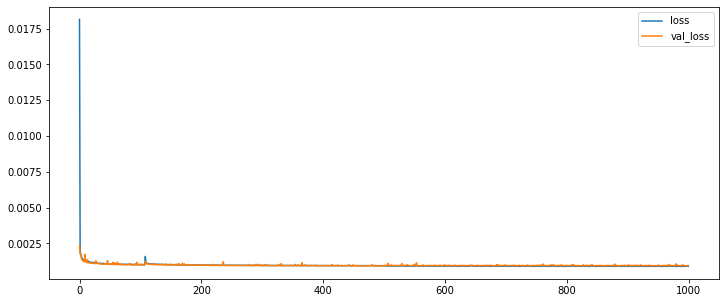

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.2
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 22.0
		5.11. PSNR: 24.1
		5.12. PSNR: 24.2
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.335

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

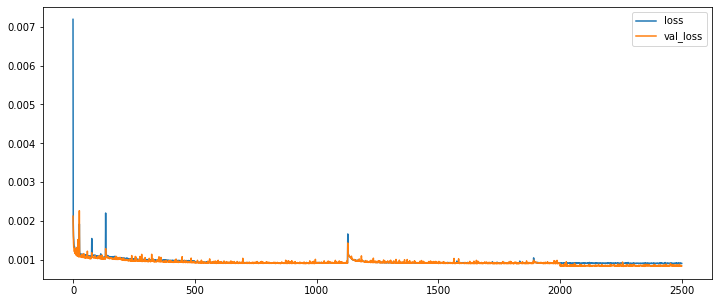

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.4
		5.3. PSNR: 28.2
		5.4. PSNR: 20.8
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.7
		5.11. PSNR: 24.1
		5.12. PSNR: 24.4
		5.13. PSNR: 28.1
		5.14. PSNR: 20.7
	Average PSNR: 24.386

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

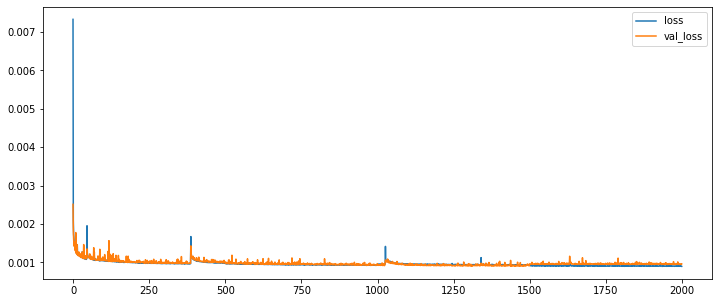

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.6
		5.11. PSNR: 24.1
		5.12. PSNR: 24.2
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.337

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

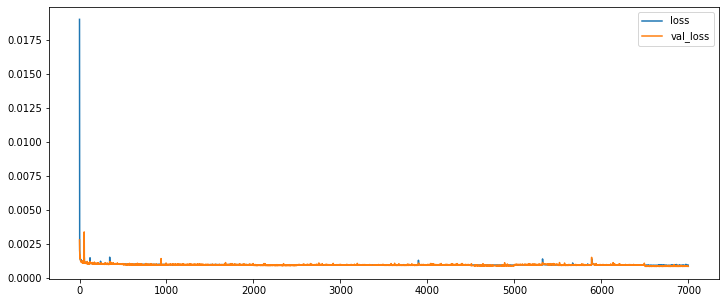

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.4
		5.3. PSNR: 28.1
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.6
		5.11. PSNR: 24.1
		5.12. PSNR: 24.5
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.366

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

In [5]:
result_strings = []
testing_images_14 = import_from_file(set14_eval_folder)
epochs_per_loop = 500
batch_size = 64
scaling_factor = 2

for label, rot, chan, im, files in test_list:
    print(f"\n\nBuilding model: {label}\n-----------------------------------------------")
    # Build new model.
    srcnn_m = SRCNN(num_channels=3, f1=9, f3=5, n1=64, n2=32, nlin_layers=1,
                    activation='relu', optimizer='adam', loss='mse', metrics=['accuracy'], padding='valid', batch_norm=False)
    
    # Instantiate generator and train.
    train_gen = SRCNNTrainingGenerator(files, 20_000)
    loss_list = []
    val_loss_list = []
    for ix in range(train_gen.__len__()):
        xdata, ydata = train_gen.__getitem__(ix)
        srcnn_m.fit(xdata=xdata, ydata=ydata, epochs=epochs_per_loop, batch_size=batch_size, validation_split=0.1, verbose=0)
        loss_list.append(srcnn_m.result.history['loss'])
        val_loss_list.append(srcnn_m.result.history['val_loss'])
    #srcnn_m.result = srcnn_m.model.fit(train_gen, epochs=100, verbose=1)
    #srcnn_m.scale = scaling_factor
    
    _, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.plot(np.concatenate(loss_list), label='loss')
    ax.plot(np.concatenate(val_loss_list), label='val_loss')
    plt.legend()
    plt.show()
    
    # Evaluate performance.
    psnr_14, psnr_bicubic_14 = srcnn_m.benchmark(testing_images_14, metric='psnr', return_metrics=True)
    ssim_14, ssim_bicubic_14 = srcnn_m.benchmark(testing_images_14, metric='ssim', return_metrics=True)
    
    # Record performance.
    rot_check = '$\\checkmark$' if rot else ''
    chan_check = '$\\checkmark$' if chan else ''
    mult_check = '$\\checkmark$' if im else ''
    result_strings.append(
        f"| ${scaling_factor}\\times$ | Set14 | {rot_check} | {chan_check} |"+
        f" ${np.mean(psnr_bicubic_14):.2f}$ dB | ${np.mean(psnr_14):.2f}$ dB |"+
        f" $+{np.mean(psnr_14) - np.mean(psnr_bicubic_14):.2f}$ dB |"+
        f" ${np.mean(ssim_bicubic_14):.2f}$ | ${np.mean(ssim_14):.2f}$ | $+{np.mean(ssim_14) - np.mean(ssim_bicubic_14):.2f}$ |"
    )


In [6]:
print(f"| Scaling factor | Image Set | Rotations | Channel Swap | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |")
print(f"| :------------- | :-------: | :-------: | :----------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |")
for p in result_strings:
    print(p)

| Scaling factor | Image Set | Rotations | Channel Swap | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |
| :------------- | :-------: | :-------: | :----------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |
| $2\times$ | Set14 |  |  | $23.54$ dB | $24.33$ dB | $+0.80$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | $\checkmark$ |  | $23.54$ dB | $24.39$ dB | $+0.85$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 |  | $\checkmark$ | $23.54$ dB | $24.34$ dB | $+0.80$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | $\checkmark$ | $\checkmark$ | $23.54$ dB | $24.37$ dB | $+0.83$ dB | $0.65$ | $0.69$ | $+0.04$ |


**Results after 300 epochs in batches of 64, pulled 20,000 at a time from file:**

| Scaling factor | Image Set | Rotations | Channel Swap | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |
| :------------- | :-------: | :-------: | :----------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |
| $2\times$ | Set14 |  |  | $23.54$ dB | $24.33$ dB | $+0.80$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | $\checkmark$ |  | $23.54$ dB | $24.39$ dB | $+0.85$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 |  | $\checkmark$ | $23.54$ dB | $24.34$ dB | $+0.80$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | $\checkmark$ | $\checkmark$ | $23.54$ dB | $24.37$ dB | $+0.83$ dB | $0.65$ | $0.69$ | $+0.04$ |

### Model defintion
Define the model first. Data must be imported on the fly as there are too many options to store the full training data set in memory at the same time (potentially).

---
### CIFAR-10 Examples
We use the CIFAR-10 dataset as a "real world" application where there is no target with which to compare. We upscale using both the trained SRCNN and bicubic interpolation, and compare visually (there is no metric in this case).

Images are saved with tags so they can be included in the summary and compare across the three scaling factors.

In [8]:
from tensorflow.keras.datasets.cifar10 import load_data

# Data import and definition.
d_example_index = {'airplane': 30,
                   'automobile': 32,
                   'bird': 90,
                   'cat': 91,
                   'deer': 130,
                   'dog': 156,
                   'frog': 72,
                   'horse': 152,
                   'ship': 62,
                   'truck': 122}

(x_train, y_train), (x_test, y_test) = load_data()
del x_test
del y_test
del y_train

label_list, im_list = [], []
for di in d_example_index.keys():
    label_list.append(di)
    im_list.append(x_train[d_example_index[di]])

im_list = np.array(im_list) / 255.0

del x_train
# Save image string.
im_prefix = f'srcnn_rotation_channelSwap_multisizeImage_{scaling_factor}x_'

In [9]:
im_pred = srcnn_model.predict(im_list)
im_scale = center_crop(
    images=scale_batch(im_list, (im_list.shape[2]*scaling_factor, im_list.shape[1]*scaling_factor)),
    remove_edge=(im_list.shape[1]*scaling_factor - im_pred.shape[1])//2)

print((im_list.shape[1]*scaling_factor - im_pred.shape[1])//2, im_list.shape[1]*scaling_factor, im_pred.shape[1])

8 128 112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


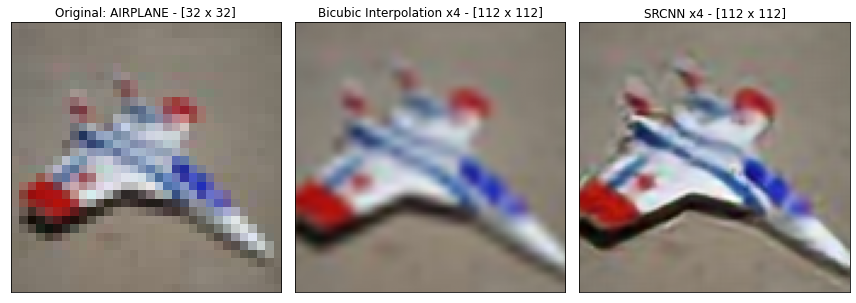

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


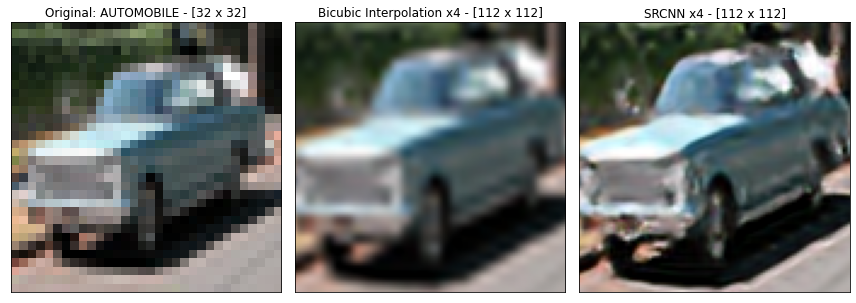

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


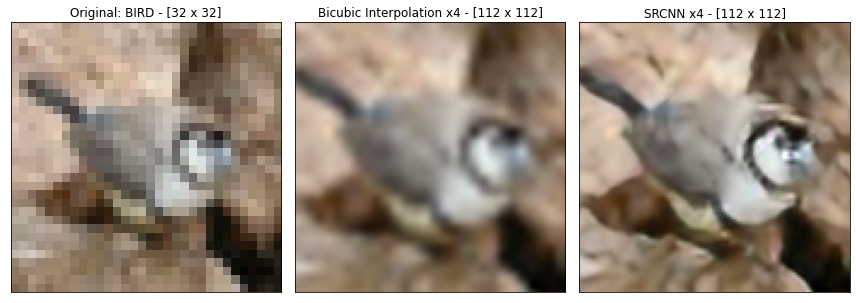

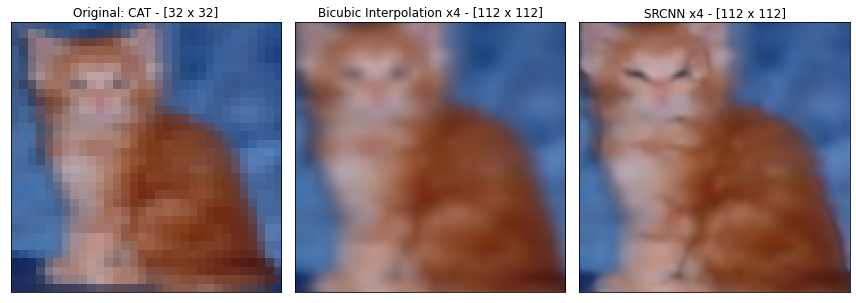

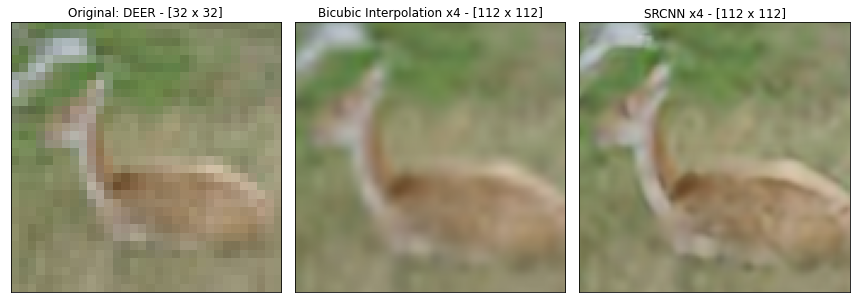

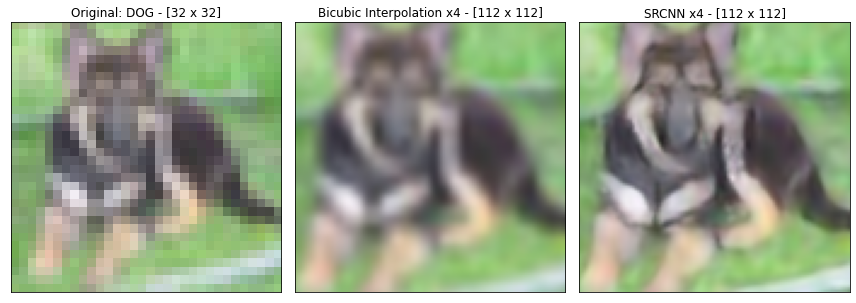

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


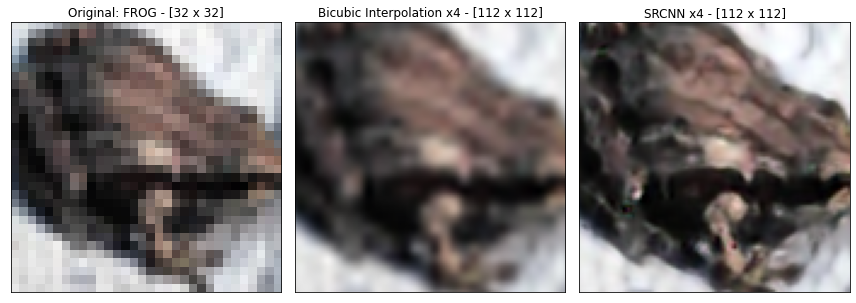

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


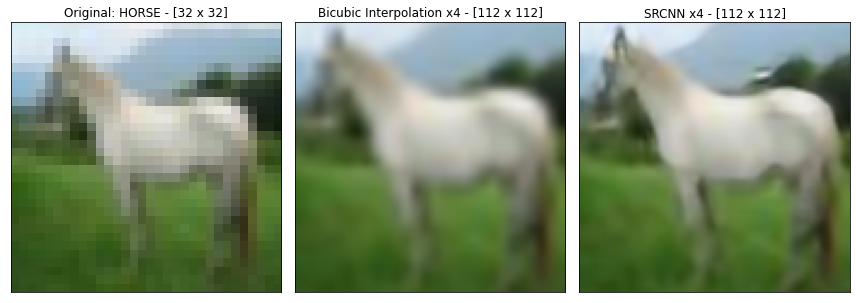

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


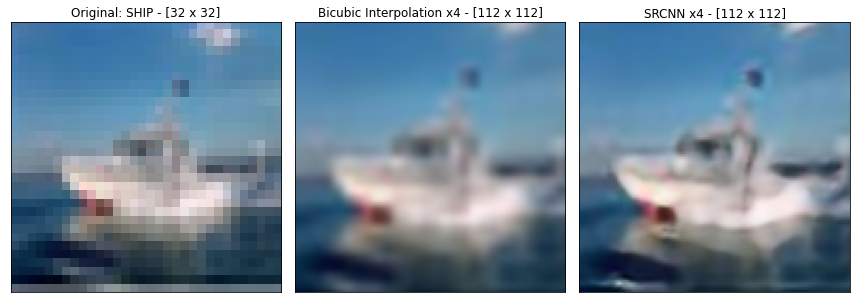

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


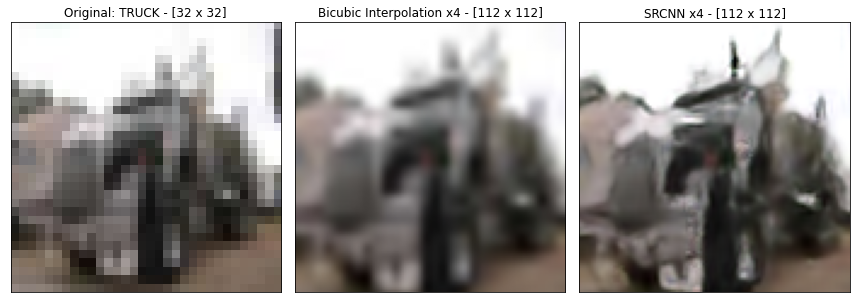

In [10]:
for label, image_raw, image_pred, image_scale in zip(label_list, list(im_list), list(im_pred), list(im_scale)):
    n_compare(
        im_list=[image_raw, image_scale, image_pred],
        label_list=[f'Original: {label.upper()} - [{image_raw.shape[1]} x {image_raw.shape[0]}]',
                    f'Bicubic Interpolation x{scaling_factor} - [{image_scale.shape[1]} x {image_scale.shape[0]}]',
                    f'SRCNN x{scaling_factor} - [{image_pred.shape[1]} x {image_pred.shape[0]}]'],
        figsize=(12,5))
    
    #im = Image.fromarray(np.uint8(image_pred*255))
    #im.save(f"results/{im_prefix}{label}.png")